## Importing libraries

In [1]:
import os
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.optimizers import Adam
import scipy.io
import matplotlib.pyplot as plt
from tensorflow.keras.applications import EfficientNetB7
from tensorflow.keras import layers, models, optimizers
from PIL import Image, ImageOps

## Reading data

In [2]:
def load_dataset(image_dir, gt_dir, target_size=(224, 224)):
    X = []
    y = []
    c = 0
    image_files = [f for f in os.listdir(image_dir) if f.endswith('.jpg')]
    image_files.sort()  # opcjonalnie

    if not image_files:
        raise ValueError("Brak plików .jpg w podanym katalogu!")

    for img_file in image_files:
        img_path = os.path.join(image_dir, img_file)
        mat_path = os.path.join(gt_dir, 'GT_' + img_file.replace('.jpg', '.mat'))

        # Wczytaj i przeskaluj obraz do dokładnego rozmiaru target_size (bez paddingu)
        img = Image.open(img_path).convert('RGB')
        img_resized = img.resize(target_size, Image.LANCZOS)

        # Konwersja do numpy + preprocess_input (dla MobileNet)
        img_array = np.array(img_resized, dtype=np.float32)
        img_array = preprocess_input(img_array)

        # Wczytaj ground truth (liczba osób)
        mat = scipy.io.loadmat(mat_path)
        count = len(mat['image_info'][0][0][0][0][0])

        X.append(img_array)
        y.append(count)
        # if c == 1:
        #     plt.imshow(img_resized)
        #     print(img_path)
        #     print(count)
        #     break
        # c += 1

    return np.array(X), np.array(y)

## Getting the training set and the test set

In [3]:
X_train, y_train = load_dataset('ShanghaiTech/part_B/train_data/images/', 'ShanghaiTech/part_B/train_data/ground-truth/')

In [4]:
X_test, y_test = load_dataset('ShanghaiTech/part_B/test_data/images/', 'ShanghaiTech/part_B/test_data/ground-truth/')

## Building the model

In [5]:
# Load pre-trained model without top classifier layers
base_model = EfficientNetB7(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze base model

# base_model.trainable = True
# for layer in base_model.layers[:-30]: # Unfreeze last 30 layers
#     layer.trainable = False

model = models.Sequential([
    base_model,
    layers.Flatten(),
    layers.Dropout(0.3),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='linear')
])

model.compile(optimizer=Adam(1e-4), loss='mse', metrics=['mae'])

## Data augmentation and training the model

In [6]:
# Function to augment
data_augmentation = tf.keras.Sequential([
    RandomFlip("horizontal"),
    RandomRotation(0.1),
    RandomZoom(0.1),
])

def augment(x, y):
    return data_augmentation(x), y

training_set = tf.data.Dataset.from_tensor_slices((X_train, y_train))
training_set = training_set.map(augment)  # augment
training_set = training_set.batch(32).prefetch(tf.data.AUTOTUNE)
history = model.fit(training_set, batch_size=32,
    epochs=20, shuffle=True, validation_data=(X_test, y_test)
)

Epoch 1/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 157s 9s/step - loss: 21551.4297 - mae: 112.4264 - val_loss: 10660.6689 - val_mae: 66.7835
Epoch 2/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 103s 8s/step - loss: 10223.7148 - mae: 73.1471 - val_loss: 7899.3071 - val_mae: 68.7681
Epoch 3/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 105s 8s/step - loss: 8783.3057 - mae: 72.8756 - val_loss: 7400.5000 - val_mae: 65.9853
Epoch 4/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 103s 8s/step - loss: 7129.3145 - mae: 64.0635 - val_loss: 6951.7588 - val_mae: 59.3324
Epoch 5/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 103s 8s/step - loss: 7088.2251 - mae: 59.8860 - val_loss: 6577.6636 - val_mae: 56.3159
Epoch 6/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 105s 8s/step - loss: 6576.6509 - mae: 58.0899 - val_loss: 6201.9497 - val_mae: 53.9955
Epoch 7/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 104s 8s/step - loss: 6178.9478 - mae: 57.5574 - val_loss: 5955.9795 - val_mae: 50.8251
Epoch 8/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 104s 8s/step - loss: 6109.4536 - mae: 57.3980 - val_loss: 5664.4932 - val_mae: 48.8

## Training curves visualisation

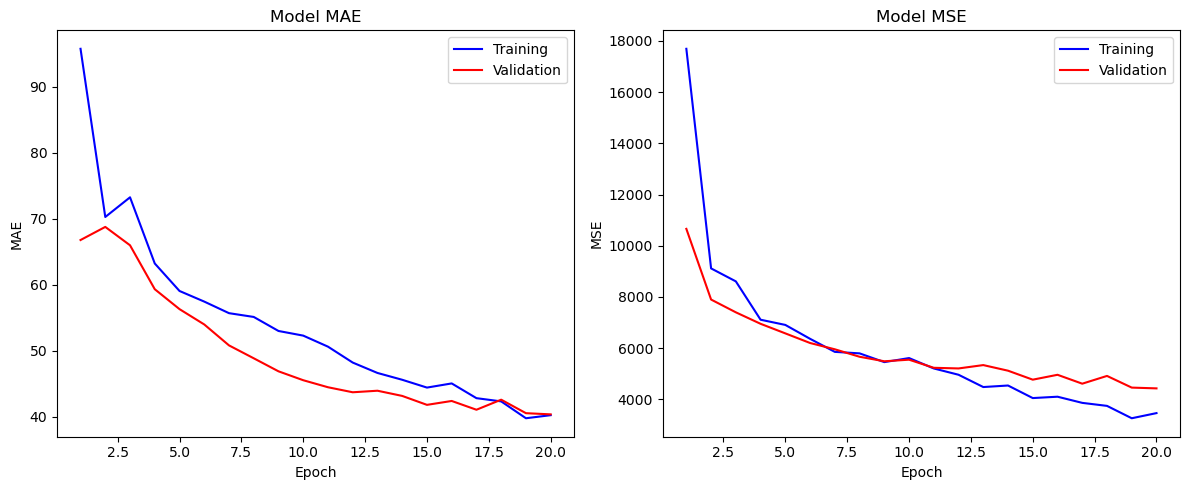

In [7]:
history_dict = history.history

# Getting the metrics
mae = history_dict['mae']
val_mae = history_dict.get('val_mae')
loss = history_dict['loss']
val_loss = history_dict.get('val_loss')

epochs = range(1, len(mae) + 1)

# MAE
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, mae, 'b-', label='Training')
if val_mae:
    plt.plot(epochs, val_mae, 'r-', label='Validation')
plt.title('Model MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

# Loss (MSE)
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'b-', label='Training')
if val_loss:
    plt.plot(epochs, val_loss, 'r-', label='Validation')
plt.title('Model MSE')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()

plt.tight_layout()
plt.show()

## Making predictions

In [8]:
y_pred = np.round(model.predict(X_test))

10/10 ━━━━━━━━━━━━━━━━━━━━ 64s 6s/step  


In [9]:
y_pred.reshape(len(y_pred), 1)
y_test.reshape(len(y_test), 1)
print(np.concatenate((y_pred.reshape(len(y_pred), 1), y_test.reshape(len(y_test), 1)), 1))

[[ 14.  23.]
 [133. 181.]
 [164. 157.]
 [ 62.  37.]
 [109.  70.]
 [ 53.  57.]
 [ 26.  44.]
 [177. 227.]
 [165. 165.]
 [202. 476.]
 [124. 139.]
 [185. 316.]
 [126. 164.]
 [156. 110.]
 [ 35.  20.]
 [129. 131.]
 [ 55.  48.]
 [165. 183.]
 [143. 101.]
 [186. 204.]
 [ 85.  40.]
 [108. 143.]
 [130. 146.]
 [243. 513.]
 [ 64.  70.]
 [ 85. 175.]
 [ 38.  51.]
 [ 70.  55.]
 [ 36.  67.]
 [ 79.  72.]
 [ 33.  56.]
 [124. 165.]
 [ 13.  32.]
 [106. 149.]
 [ 69.  48.]
 [108.  80.]
 [ 70. 117.]
 [ 56. 162.]
 [186. 137.]
 [158. 120.]
 [112.  72.]
 [131. 122.]
 [126. 198.]
 [ 89. 133.]
 [102. 147.]
 [ 25.  29.]
 [ 11.  70.]
 [ 30.  35.]
 [ 62.  24.]
 [197. 251.]
 [ 72.  59.]
 [108.  67.]
 [ 71.  61.]
 [172. 248.]
 [175. 252.]
 [168. 147.]
 [ 15.  57.]
 [104. 121.]
 [ 36.  47.]
 [214. 505.]
 [147. 297.]
 [191. 465.]
 [118. 167.]
 [ 54.  43.]
 [ 60.  46.]
 [115.  91.]
 [181. 263.]
 [117.  92.]
 [119. 117.]
 [ 52.  48.]
 [ 93.  54.]
 [ 73.  73.]
 [ 89. 122.]
 [111.  60.]
 [206. 170.]
 [ 82. 167.]
 [ 45.  57.]

## Metrics

In [10]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, root_mean_squared_error
print("R2:", r2_score(y_test, y_pred))
print("MSE:", mean_squared_error(y_test, y_pred))
print("MAE:", mean_absolute_error(y_test, y_pred))
print("RMSE:", root_mean_squared_error(y_test, y_pred))

R2: 0.5109209418296814
MSE: 4426.2373046875
MAE: 40.36392593383789
RMSE: 66.52997589111328
